# Introduction Azure ML
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

## 0. Paramétrage

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
import datetime
now = datetime.datetime.now()
print(now)

2020-03-10 14:28:45.423044


In [4]:
import azureml.core
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("Version Azure ML service : ", azureml.core.VERSION)

Version Azure ML service :  1.0.83


In [5]:
# Rappel des infos du workspace Azure ML service
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: AzureMLWorkshop
Azure region: westeurope
Resource group: AzureMLWorkshopRG


In [6]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores:")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)


Compute Targets:
Datastores:
	 azureml_globaldatasets : AzureBlob
	 workspacefilestore : AzureFile
	 workspaceblobstore : AzureBlob
Datasets:


## 1. Chargement des données

In [7]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [8]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [9]:
# Partitionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [10]:
print ("Training =", len(data['train']['X']), 'observations')

Training = 353 observations


In [11]:
print ("Test =", len(data['test']['X']), 'observations')

Test = 89 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



In [12]:
experiment = Experiment(workspace=ws, name="exemple1-IntroductionAML")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles
4. Sauvegarde modèle

In [13]:
def regridge(alpha):
    
    from datetime import datetime
    maintenant = datetime.now()
    print("Maintenant : ", maintenant)

    # 1. Run
    run = experiment.start_logging()
    print('Alpha = ', alpha)
    
    # 2. Logs de valeurs
    run.log('alpha', alpha)
    run.log('date_log', str(maintenant))

    # 3. Modèle ML
    regression_model = Ridge(alpha=alpha)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log des métriques
    print('MSE =', mean_squared_error(data['test']['y'], preds))
    run.log('mse', mean_squared_error(data['test']['y'], preds))

    # 5. Export modèle
    joblib.dump(value=regression_model, filename='modelenotebook1.pkl')

    # 6. Ajout de tags au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AMLS", "1.0.74")
    run.tag("Team", "DataScience")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 6. Fin
    run.complete()

Rappel: Définition MSE
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e258221518869aa1c6561bb75b99476c4734108e">

In [14]:
regridge(0.1)

Maintenant :  2020-03-10 14:29:16.713412
Alpha =  0.1
MSE = 3372.649627810032


In [15]:
regridge(0.2)

Maintenant :  2020-03-10 14:29:34.537001
Alpha =  0.2
MSE = 3325.2946794678764


In [16]:
regridge(0.3)

Maintenant :  2020-03-10 14:29:52.545304
Alpha =  0.3
MSE = 3302.6736334017255


In [17]:
# On regarde si on a bien téléchargé le pickle du modèle
%ls modelenotebook1.pkl -l

-rwxrwxrwx 1 root root 645 Mar 10 14:30 modelenotebook1.pkl*


In [18]:
# Liste des métriques par Run
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['exemple1-IntroductionAML']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID =', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID = 6291a4ce-da36-492b-98ed-1b42f3dc82c3
- date_log 2020-03-10 14:29:52.545304
- mse 3302.6736334017255
- alpha 0.3
Run ID = 506b4467-5e82-4ccf-892c-737e296b0d32
- alpha 0.2
- mse 3325.2946794678764
- date_log 2020-03-10 14:29:34.537001
Run ID = e61d8db4-0d93-481d-9b8a-e1b8a2f00065
- alpha 0.1
- date_log 2020-03-10 14:29:16.713412
- mse 3372.649627810032


> Nous pouvons visualiser les résultats sur le portail dans la section **experiments**

## 3. Utilisation MLFlow

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-use-mlflow/mlflow-diagram-track.png">

Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-use-mlflow

> https://mlflow.org/

In [19]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

In [20]:
#pip install azureml-mlflow

In [21]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment_name = "Exemple1-MLFlow"
mlflow.set_experiment(experiment_name)

INFO: 'Exemple1-MLFlow' does not exist. Creating a new experiment


Data contains 353 training samples and 89 test samples
Mean Squared Error is 3295.741064355809


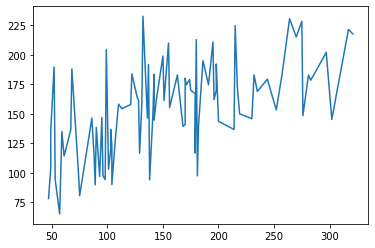

In [22]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")

model_save_path = "model"

with mlflow.start_run() as run:
    # Log the algorithm parameter alpha to the run
    mlflow.log_metric('alpha', 0.4)
    # Create, fit, and test the scikit-learn Ridge regression model
    regression_model = Ridge(alpha=0.4)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # Log mean squared error
    print('Mean Squared Error is', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    # Save the model to the outputs directory for capture
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    # Plot actuals vs predictions and save the plot within the run
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("actuals_vs_predictions.png")
    mlflow.log_artifact("actuals_vs_predictions.png")
    

In [23]:
ws.experiments[experiment_name]

Name,Workspace,Report Page,Docs Page
Exemple1-MLFlow,AzureMLWorkshop,Link to Azure Machine Learning studio,Link to Documentation


## 4. Autres exemples de logging d'informations

In [24]:
experiment = Experiment(workspace=ws, name='Exemple1-Logging')

In [25]:
from tqdm import tqdm

In [26]:
# start logging for the run
run = experiment.start_logging()

# change the scale factor on different runs to see how you can compare multiple runs
scale_factor = 3

# change the category on different runs to see how to organize data in reports
category = 'Rouge'

In [27]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple1-Logging,b5129b42-4fb6-4a80-ad70-f8b99a271bb0,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [28]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,AzureMLWorkshop,Link to Azure Machine Learning studio,Link to Documentation


In [29]:
# log chaine de caractères
run.log(name='Category', value=category)

In [30]:
# log donneés numériques
run.log(name="scale factor", value = scale_factor)
run.log(name='Magic Number', value=42 * scale_factor)

In [31]:
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run.log_list(name='Fibonacci', value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run.log(name='Sigmoid', value=1 / (1 + np.exp(-i)))

100%|██████████| 20/20 [00:00<00:00, 8632.92it/s]


In [32]:
# create a dictionary to hold a table of values
sines = {}
sines['angle'] = []
sines['sine'] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * scale_factor
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run.log_row(name='Cosine Wave', angle=angle, cos=np.cos(angle))
        
    sines['angle'].append(angle)
    sines['sine'].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run.log_table(name='Sine Wave', value=sines)

100%|██████████| 20/20 [00:00<00:00, 5376.97it/s]


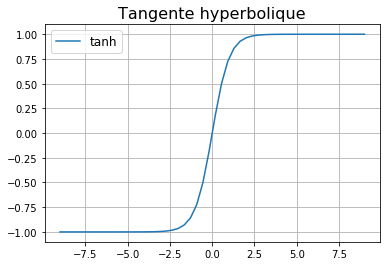

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
angle = np.linspace(-3, 3, 50) * scale_factor
plt.plot(angle,np.tanh(angle), label='tanh')
plt.legend(fontsize=12)
plt.title('Tangente hyperbolique', fontsize=16)
plt.grid(True)

run.log_image(name='Hyperbolic Tangent', plot=plt)

In [34]:
file_name = 'outputs/myfile.txt'

with open(file_name, "w") as f:
    f.write('This is an output file that will be uploaded.\n')

# Upload the file explicitly into artifacts 
run.upload_file(name = file_name, path_or_stream = file_name)

In [35]:
run.complete()

In [36]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,AzureMLWorkshop,Link to Azure Machine Learning studio,Link to Documentation


## 5. Azure Open Datasets
<img src="https://github.com/retkowsky/images/blob/master/opendata.jpg?raw=true">

> https://azure.microsoft.com/fr-fr/services/open-datasets/

In [37]:
#!pip install azureml-opendatasets

In [38]:
# Dataset jours fériés
from azureml.opendatasets import PublicHolidays

from datetime import datetime
from dateutil import parser
from dateutil.relativedelta import relativedelta

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/multimethods/__init__.py:106: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  dispatcher.typemap.append((self.types, self.condition, function, inspect.getargspec(function)))


In [39]:
# Intervalle
end_date = datetime.today() + relativedelta(months=24)
start_date = datetime.today() - relativedelta(months=24)

In [40]:
hol = PublicHolidays(start_date=start_date, end_date=end_date)
joursferies = hol.to_pandas_dataframe()

Looking for parquet files...
Reading them into Pandas dataframe...
Reading Processed/part-00000-tid-4367650426649658458-f960263d-f41a-4841-941a-f0d229577da6-649-c000.snappy.parquet under container holidaydatacontainer
Done.


In [41]:
joursferies.shape

(2224, 6)

In [42]:
joursferies.head()

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
24897,Norway,Søndag,Søndag,None,NO,2018-03-11
24898,Sweden,Söndag,Söndag,None,SE,2018-03-11
24899,Hungary,Nemzeti ünnep,Nemzeti ünnep,None,HU,2018-03-15
24900,Hungary,Nemzeti ünnep utáni pihenőnap,Nemzeti ünnep utáni pihenőnap,None,HU,2018-03-16
24901,Ireland,St. Patrick's Day,St. Patrick's Day,None,IE,2018-03-17


In [43]:
joursferiesFR=joursferies[joursferies.countryRegionCode == 'FR']

In [44]:
joursferiesFR

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
24967,France,Lundi de Pâques,Lundi de Pâques,None,FR,2018-04-02
25015,France,Fête du Travail,Fête du Travail,None,FR,2018-05-01
25044,France,Armistice 1945,Armistice 1945,None,FR,2018-05-08
25051,France,Ascension,Ascension,None,FR,2018-05-10
25074,France,Lundi de Pentecôte,Lundi de Pentecôte,None,FR,2018-05-21
25138,France,Fête nationale,Fête nationale,None,FR,2018-07-14
25164,France,Assomption,Assomption,None,FR,2018-08-15
25234,France,Toussaint,Toussaint,None,FR,2018-11-01
25251,France,Armistice 1918,Armistice 1918,None,FR,2018-11-11
25309,France,Noël,Noël,None,FR,2018-12-25


<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">